**IMPORT LIBS**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from torch.optim.lr_scheduler import ReduceLROnPlateau

**GPU SUPPORT**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**LOAD DATASET**

In [3]:
train_df = pd.read_csv('/content/tweet_train.csv')
test_df  = pd.read_csv('/content/tweet_test.csv')

In [4]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


**CLEAN INPUT TEXT**

In [6]:
# Define the clean_text function
def clean_text(text):
    if not isinstance(text, str):
        text = " "
    text = re.sub(r'[@#/\\|]', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s!*\']', '', text)
    return text

# Clean text using looping over sentence in
for i in range(len(train_df)):
    train_df.at[i, 'text'] = clean_text(train_df.at[i, 'text'])
    train_df.at[i, 'selected_text'] = clean_text(train_df.at[i, 'selected_text'])

for i in range(len(test_df)):
    test_df.at[i, 'text'] = clean_text(test_df.at[i, 'text'])

In [7]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,Id have responded if I were going,Id have responded if I were going,neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,Sons of **** why couldnt they put them on the...,Sons of ****,negative


In [8]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http twitpiccom 67ezh,neutral
1,96d74cb729,Shanghai is also really exciting precisely s...,positive
2,eee518ae67,Recession hit Veronique Branquinho she has to ...,negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http twitpiccom 4w75p I like it!!,positive


**OUTPUT LABEL => NUMERICS (SENTIMENT MAPPING)**

In [9]:
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
train_df['sentiment'] = train_df['sentiment'].map(sentiment_map)
test_df['sentiment'] = test_df['sentiment'].map(sentiment_map)

**TOKENIZE THE INPUT**

In [10]:
# Make tokenizer varibale of bert
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 100

# Tokenizing func
def tokenize_data(texts, tokenizer, MAX_LEN):
    encoded_text = tokenizer(texts, max_length=MAX_LEN, padding='max_length', truncation=True, return_tensors='pt')
    return encoded_text['input_ids'], encoded_text['attention_mask']

# Tokenize the input (text)
train_input_ids, train_attention_mask = tokenize_data(train_df['text'].tolist(), tokenizer, MAX_LEN)
test_input_ids, test_attention_mask = tokenize_data(test_df['text'].tolist(), tokenizer, MAX_LEN)

train_labels = torch.tensor(train_df['sentiment'].tolist(), dtype=torch.long)
test_labels = torch.tensor(test_df['sentiment'].tolist(), dtype=torch.long)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

**CUSTOM DATASET,DATALOADER**

In [11]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'label': self.labels[idx]
        }

# Create datasets
train_ds = CustomDataset(train_input_ids, train_attention_mask, train_labels)
test_ds = CustomDataset(test_input_ids, test_attention_mask, test_labels)

# Create dataloaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)


**MODEL**

In [12]:
# Build model
class SentimentModel(nn.Module):
    def __init__(self, output_size, hidden_size):
        super(SentimentModel, self).__init__()
        self.bert = AutoModel.from_pretrained('bert-base-uncased')

        # Freeze BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False

        self.rnn = nn.RNN(input_size=768, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Bidirectional doubles the hidden size

    def forward(self, input_ids, attention_masks):
        with torch.no_grad():
            outputs = self.bert(input_ids, attention_mask=attention_masks)
        last_hidden_state = outputs.last_hidden_state
        rnn_out, _ = self.rnn(last_hidden_state)
        logits = self.fc(rnn_out[:, -1, :])  # Use the output of the last token <=> [batch_size,sequence_length,hidden_size]
        return logits

**HYPERPARAMS , INTILIAZE MODEL**

In [13]:
# Hyperparameters
hidden_size = 512
output_size = 3
num_epochs = 10
learning_rate = 0.001

# Initialize model, loss,optimizer and scheduler
model = SentimentModel(output_size, hidden_size).to(device)  # Move model to GPU if available
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

**TRAIN AND TEST LOOP**

In [14]:
# Training function
def train_with_test(model, train_loader, test_loader, criterion, optimizer, num_epochs,early_patience = 3,scheduler=None):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    best_loss = float('inf')


    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, correct, total = 0, 0, 0
        for batch in train_loader:
            inputs = batch['input_ids'].to(device)  # Move data to GPU
            masks = batch['attention_mask'].to(device)  # Move data to GPU
            labels = batch['label'].to(device)  # Move data to GPU

            #forw
            outputs = model(inputs, masks)
            #loss
            loss = criterion(outputs, labels)
            #zero_grad
            optimizer.zero_grad()
            #backprop
            loss.backward()
            #update wts,bias
            optimizer.step()
            #store batch loss,total sample,correct predictions
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = (correct / total)*100
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)

        # Evaluation phase
        model.eval()
        test_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch in test_loader:
                inputs = batch['input_ids'].to(device)
                masks = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                #forw
                outputs = model(inputs, masks)
                #loss
                loss = criterion(outputs, labels)
                 #store batch loss,total sample,correct predictions
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_test_loss = test_loss / len(test_loader)
        avg_test_acc = (correct / total)*100
        test_losses.append(avg_test_loss)
        test_accuracies.append(avg_test_acc)

        #LR Scheduling
        if scheduler:
          scheduler.step(avg_test_loss)

        #Early Stopping
        if avg_test_loss < best_loss:
            best_loss = avg_test_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= early_patience:
                print(f"Early stopping triggered at epoch {epoch+1}.")
                break

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}%, Test Loss: {avg_test_loss:.4f}, Test Acc: {avg_test_acc:.4f}%")

    model.load_state_dict(torch.load('best_model.pth'))
    return train_losses, test_losses, train_accuracies, test_accuracies

**PLOT LOSS AND ACCURACY**

In [15]:
# Plot metrics
def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

**RUN THE MODEL**

Epoch 1/10, Train Loss: 1.0721, Train Acc: 41.8253%, Test Loss: 1.0561, Test Acc: 43.6333%
Epoch 2/10, Train Loss: 1.0419, Train Acc: 46.1555%, Test Loss: 1.0281, Test Acc: 47.7646%
Epoch 3/10, Train Loss: 1.0161, Train Acc: 49.6634%, Test Loss: 1.0024, Test Acc: 51.1885%
Epoch 4/10, Train Loss: 0.9911, Train Acc: 52.5709%, Test Loss: 0.9785, Test Acc: 53.0560%
Epoch 5/10, Train Loss: 0.9688, Train Acc: 54.2484%, Test Loss: 0.9557, Test Acc: 54.8104%
Epoch 6/10, Train Loss: 0.9456, Train Acc: 55.5984%, Test Loss: 0.9315, Test Acc: 56.1404%
Epoch 7/10, Train Loss: 0.9201, Train Acc: 56.8538%, Test Loss: 0.9070, Test Acc: 56.8195%
Epoch 8/10, Train Loss: 0.8928, Train Acc: 58.7642%, Test Loss: 0.8785, Test Acc: 57.5835%
Epoch 9/10, Train Loss: 0.8625, Train Acc: 59.8413%, Test Loss: 0.8478, Test Acc: 58.8568%
Epoch 10/10, Train Loss: 0.8358, Train Acc: 60.7329%, Test Loss: 0.8251, Test Acc: 60.7527%


<ipython-input-14-32805e2d1574>:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


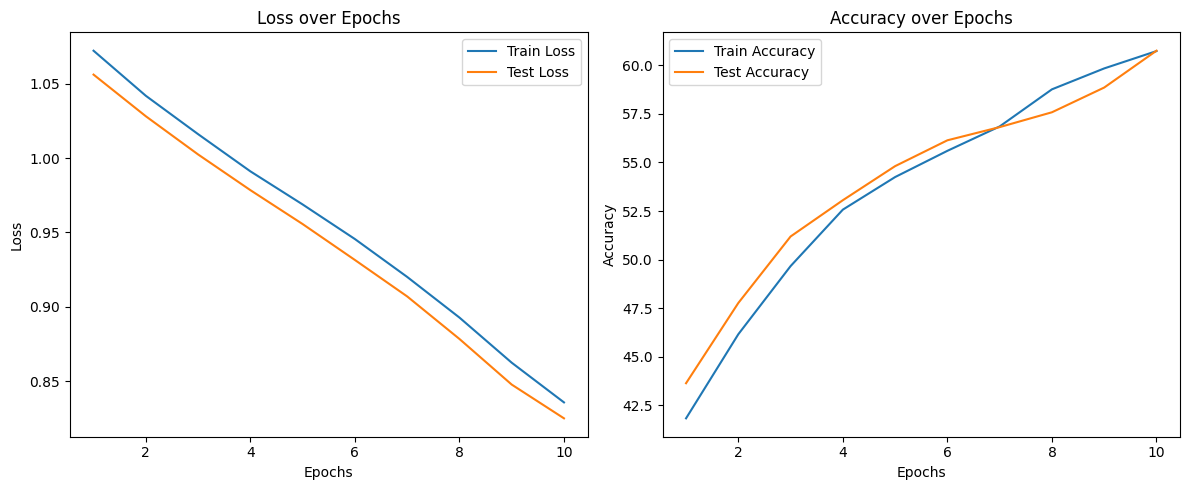

In [16]:
# Train the model
train_losses, test_losses, train_accuracies, test_accuracies = train_with_test(model, train_loader, test_loader, criterion, optimizer, num_epochs)

# Plot the results
plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)
